In [1]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]
matplotlib.rcParams['lines.linewidth'] = 2
import numpy as np
from numpy import pi, isclose
from scipy.linalg import cholesky, eigh, solve

from tudaesasII.beam2d import Beam2D, update_K, update_M, DOF


nx = 100

# geometry
Lbeam = 2
h = 0.05
w = h
Izz = h**3*w/12
A = w*h

# material properties
E = 70e9
nu = 0.33
rho = 2.6e3

# creating mesh
xmesh = np.linspace(0, Lbeam, nx)
ymesh = np.zeros_like(xmesh)
ncoords = np.vstack((xmesh.T.flatten(), ymesh.T.flatten())).T
x = ncoords[:, 0]
y = ncoords[:, 1]
nid_pos = dict(zip(np.arange(len(ncoords)), np.arange(len(ncoords))))

#NOTE using dense matrices
N = DOF*nx
K = np.zeros((N, N))
M = np.zeros((N, N))

elems = []
# creating beam elements
nids = list(nid_pos.keys())
for n1, n2 in zip(nids[:-1], nids[1:]):
    elem = Beam2D()
    elem.n1 = n1
    elem.n2 = n2
    elem.E = E
    elem.A1 = elem.A2 = A
    elem.Izz1 = elem.Izz2 = Izz
    elem.rho = rho
    elem.interpolation = 'legendre'
    update_K(elem, nid_pos, ncoords, K)
    update_M(elem, nid_pos, M, lumped=False)
    elems.append(elem)

print('elements created')

# applying boundary conditions for static problem
# cantilever
bk = np.zeros(K.shape[0], dtype=bool) #array to store known DOFs
check = isclose(x, 0.)
bk[0::DOF] = check
bk[1::DOF] = check
bk[2::DOF] = check
bk[0::DOF] = True # removing all axial displacements

u = np.zeros(K.shape[0])

bu = ~bk

Muu = M[bu, :][:, bu]
Mku = M[bk, :][:, bu]
Muk = M[bu, :][:, bk]
Mkk = M[bk, :][:, bk]

Kuu = K[bu, :][:, bu]
Kku = K[bk, :][:, bu]
Kuk = K[bu, :][:, bk]
Kkk = K[bk, :][:, bk]

L = cholesky(M, lower=True)
Luu = L[bu, :][:, bu]
Luuinv = np.linalg.inv(Luu)
Ktilde = Luuinv @ Kuu @ Luuinv.T

rbmodes = 0
Nmodes = 10
gamma, Vu = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1
Vu = Vu[:, rbmodes:]
gamma = gamma[rbmodes:]

omegan = gamma**0.5

V = np.zeros((N, Nmodes-rbmodes))
V[bu, :] = Vu

P = V
Pu = Vu

print('omegan [rad/s]', omegan)


elements created
omegan [rad/s] [   65.82334298   412.20991147  1152.85539178  2255.30247431
  3719.99131687  5542.07420961  7715.9998424  10235.26509685
 13092.50469997 16279.56803512]


C:\Users\jsodja\AppData\Local\Temp\ipykernel_16352\3272109097.py:92: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  gamma, Vu = eigh(Ktilde, eigvals=(0, Nmodes-1)) # already gives V[:, i] normalized to 1


Modal Frequency Response Analysis (with base excitation)
===
Damping matrix C calculated from modaldamping ratio
---

In [2]:
zeta = 0.02
Dm = np.zeros((Nmodes-rbmodes, Nmodes-rbmodes))
Dm[np.diag_indices_from(Dm)] = 2*zeta*omegan
C = L @ P @ Dm @ P.T @ L.T
Cuu = C[bu, :][:, bu]
Cuk = C[bu, :][:, bk]

Sine sweep analysis
---

In [3]:
amplitude = 0.001
u = np.zeros(N)
u[1] = amplitude
uk = u[bk]

displs = []
U = np.zeros(K.shape[0], dtype=np.complex128)
omegafs = np.linspace(0, 6000, 10000)
for omegaf in omegafs:
    dukdt = 1j*omegaf*uk
    d2ukdt2 = -omegaf**2*uk
    Fk = - Muk @ d2ukdt2 - Cuk @ dukdt - Kuk @ uk
    
    # NOTE Direct FRA
    # 1) Calculate the frequency response matrix
    # Huu = -Muu*omegaf**2 + Cuu*1j*omegaf + Kuu
    # 2) Solve for the displacement frequency response
    # Uu = solve(Huu, Fk)
    
    # NOTE Modal FRA
    # 1) calculate modal force
    fmodal = Pu.T @ Luuinv @ Fk
    # 2) calculate the analytical FRF
    H = 1/(-omegaf**2 + 2*zeta*1j*omegaf*omegan + omegan**2)
    # 3) calculate the modal frequency response
    r = H*fmodal
    # 4) convert modal into displacement frequency response
    Uu = Luuinv.T @ Pu @ r
    
    U[bu] = Uu
    U[1] = amplitude
    displs.append(U[1::DOF].copy())   
displs = np.asarray(displs)
print('ready!')

ready!


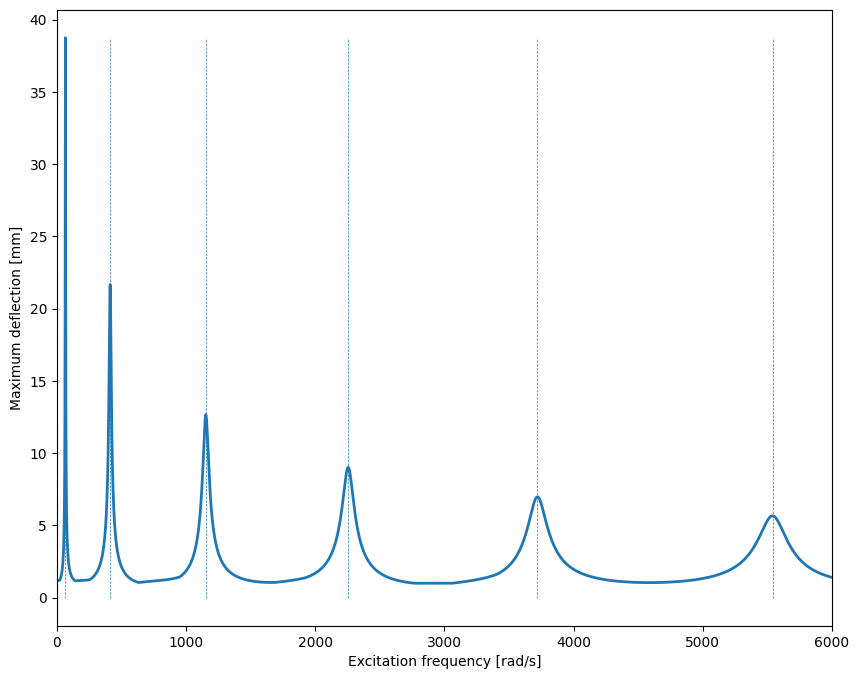

In [4]:
%matplotlib inline

plt.plot(omegafs, np.abs(displs).max(axis=1)*1000)
plt.vlines(x=[omegan[omegan < omegafs.max()]], ymin=0, ymax=np.abs(displs).max()*1000, ls='--', lw=0.5)
plt.ylabel('Maximum deflection [mm]')
plt.xlabel('Excitation frequency [rad/s]')
plt.xlim(0, 6000)
plt.show()